In [63]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [64]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time

In [65]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

<Figure size 432x288 with 0 Axes>

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2020, source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s06_06ewdichte2020

In [66]:
input_path = './../../input/zones/'
output_path = './../../output/'
model_path = './../../model/'

## Zones

Load zone data from the input files

### read in Berliner Ortsteile shapefile

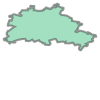

In [67]:
zones = gpd.read_file(input_path + "Berliner_Ortsteile.shp")
zones = zones.to_crs(epsg=4326)
#hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
hull

In [68]:
# remove duplicate zone entry (Buch) 
from shapely.ops import unary_union
sch = zones['sch']
dpls = list(sch[sch.duplicated()])
for dpl in dpls:
    zones['geometry'][sch == dpl][0] = unary_union([x for x in zones['geometry'][sch == dpl]])
    blIndex = [True if not row == dpl or not dpl in list(sch.iloc[:n]) else False for n, row in enumerate(sch)]
    zones = zones[blIndex]

In [69]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
# Save zones into the model
sm.zones = zones
sm.zones.plot()
sm.zones.sample(2)

### read and clean in building block shapefile

In [73]:
# Add building block shapefile
buildings = gpd.read_file(input_path + "Einwohnerdichte_2020.shp")
buildings.to_crs(epsg=4326, inplace=True)
# remove buildings without geometry property
print("removing", sum(buildings.geometry == None), 
      "buildings with",
      round(sum(buildings[buildings.geometry == None]["ew2020"])),
      "inhabitants due to lack of geometry, e.g. building with schl5 =",
     buildings[buildings.geometry == None].iloc[0]["schl5"])
buildings = buildings[buildings.geometry != None]
buildings["zone"] = None

removing 127 buildings with 4863 inhabitants due to lack of geometry, e.g. building with schl5 = None


<AxesSubplot:>

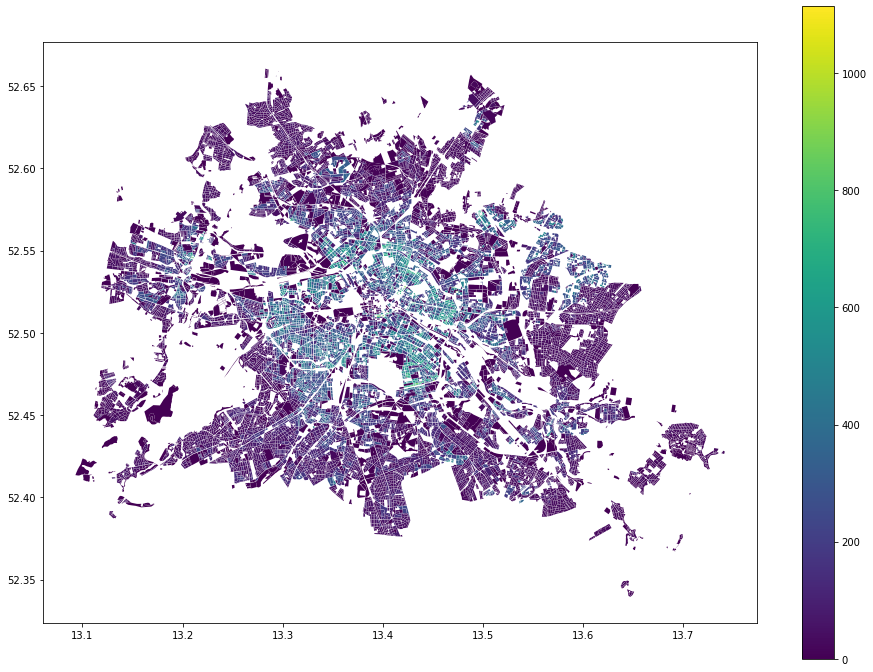

In [75]:
fig, ax = plt.subplots(figsize = (16,12))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", legend=True)

### assign a zone to each building

In [76]:
# assign zone to each building
buildings["zone"] = \
    buildings['geometry']\
        .apply(lambda g: sm.zones.index[sm.zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)


Text(0.5, 1.0, 'Assignment of buildings to zones')

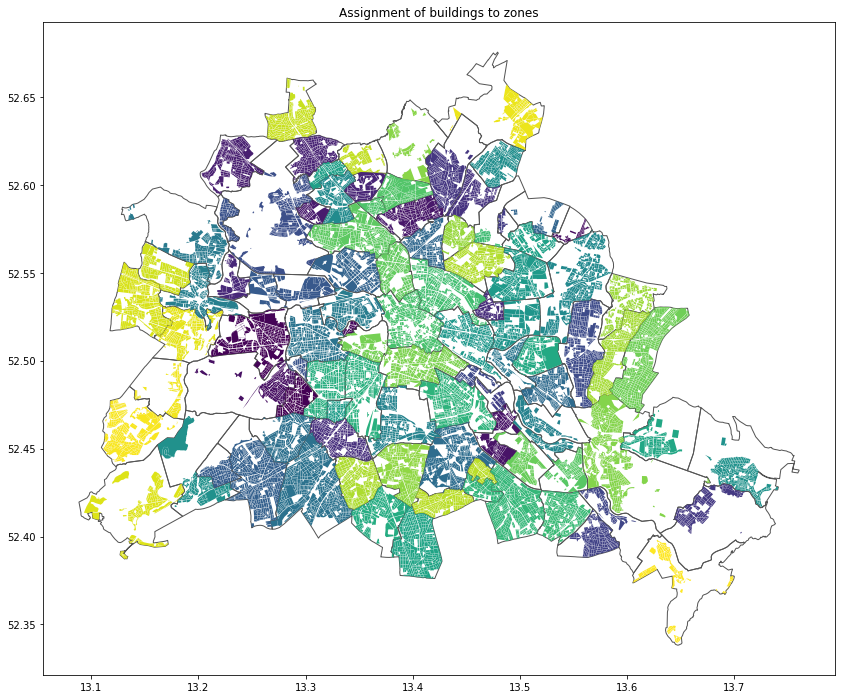

In [77]:
# plot
fig, ax = plt.subplots(figsize = (16,12))
sm.zones.plot(ax=ax, color="#ffffff00", edgecolor="#555")
buildings.plot(ax=ax, column='zone', cmap = "viridis", legend=False)
ax.set_title("Assignment of buildings to zones")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:16. Minutes remaining: 00:00. 

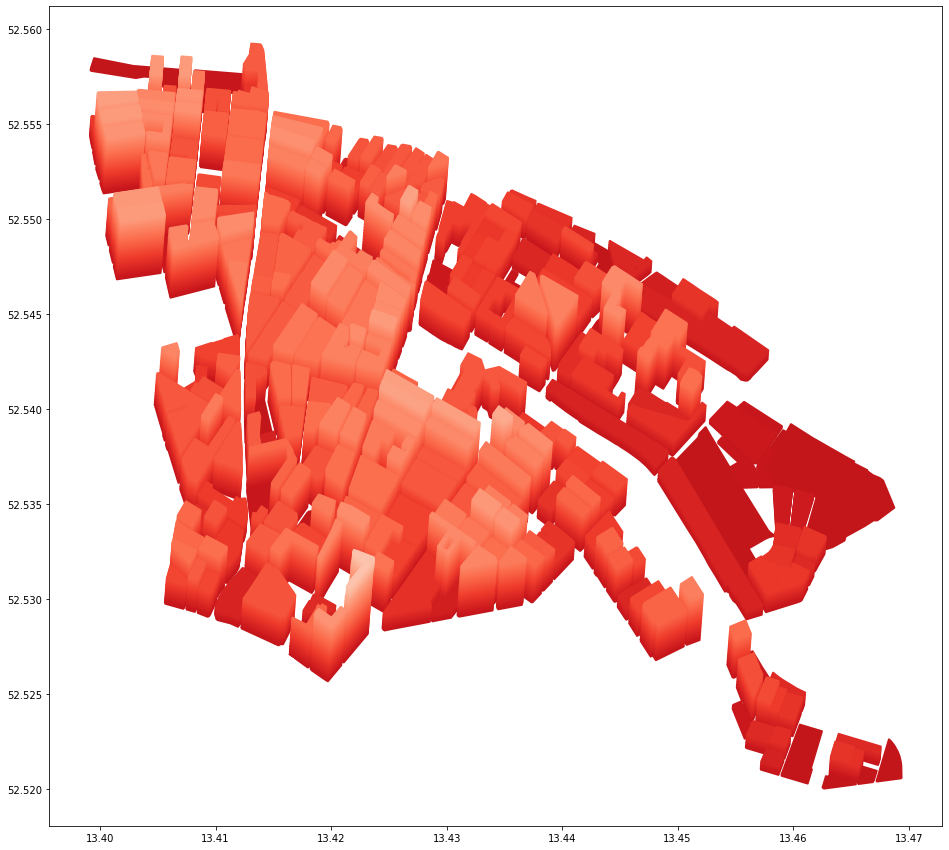

In [78]:
# some map art

from shapely.affinity import translate
from shapely.ops import unary_union
import time
sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
spb = buildings[buildings["zone"].isin(sm.zones.index[sm.zones["nam"].isin(sf)])]
bspb = unary_union(list(spb.geometry.apply(lambda g: g.buffer(0.002))))
bspb = Polygon(bspb.exterior.coords)

fig, ax = plt.subplots(figsize = (16,16))
t0 = time.time()

sm.road_links.geometry[list(sm.road_links.intersects(bspb))].apply(lambda g: g.buffer(0.00022).intersection(bspb)).plot(ax=ax, color ="grey")


maxHeight = max(spb["ew_ha_2020"])

nSteps = 50
cbuff = 40
cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

for i in range(0,nSteps):
    # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 0.00001,0.00008) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 2)
    # spb.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", linewidth = 2)
    helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)





### for each zone: sum up population from buildings and create centroids weighted by population

popCentroid (13.228250106615496, 52.580581987471035) not within polygon for zone 24 Konradshöhe


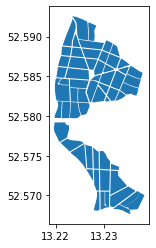

In [79]:
t0=time.time()
# sum up population from buildings to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0,0)
sm.zones["popCentroidOffset"] = LineString([Point(0,0), Point(0,0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    buildingsInZone = buildings[buildings["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2020 = sum(buildingsInZone["ew2020"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2020
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for buildingIndex, building in buildingsInZone.iterrows():
        weigthedCoords["lon"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.x
        weigthedCoords["lat"] += building["ew2020"] / zonePopulation2020 * building["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone["nam"])
        buildingsInZone.plot()
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([zone["geometry"].centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

Text(0.5, 1.0, 'Zones centroids vs population weigthed centroids')

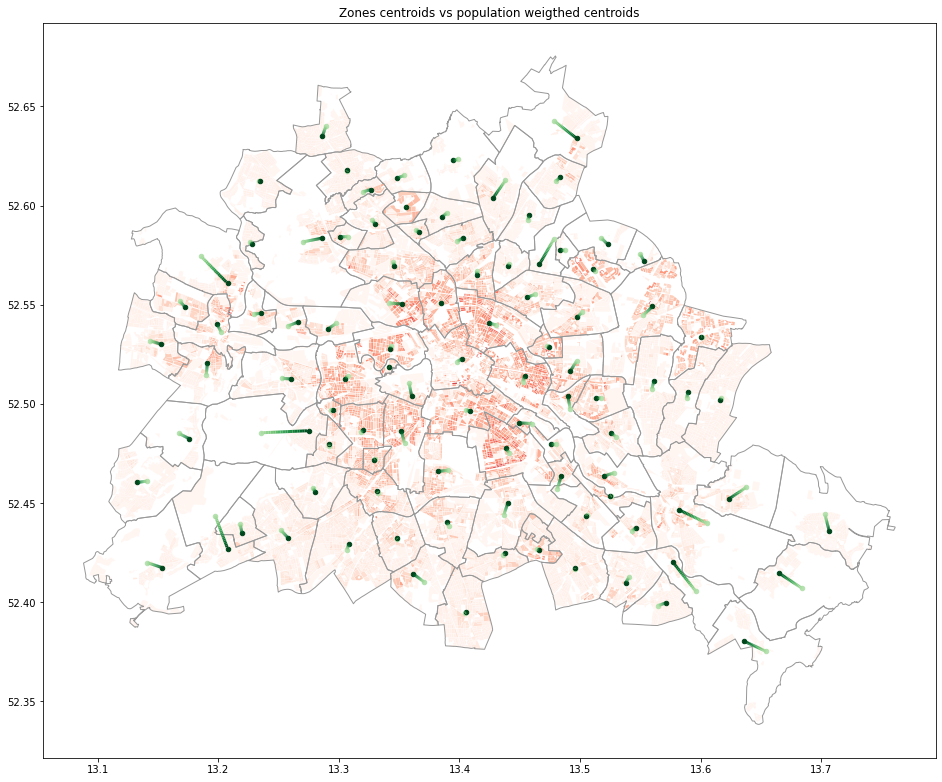

In [80]:
# show zones and popCentroids and their offsets from real geometrical centroids
fig, ax = plt.subplots(1, 1, figsize=(16,16))
buildings.plot(ax=ax, column='ew_ha_2020', cmap = "Reds")
# add zone borders and a bit of opacity
sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
nSteps = 20
cbuff = 10
cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
for i in range(1,nSteps):
    l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.popCentroidOffset]
    gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
ax.set_title("Zones centroids vs population weigthed centroids")

<AxesSubplot:>

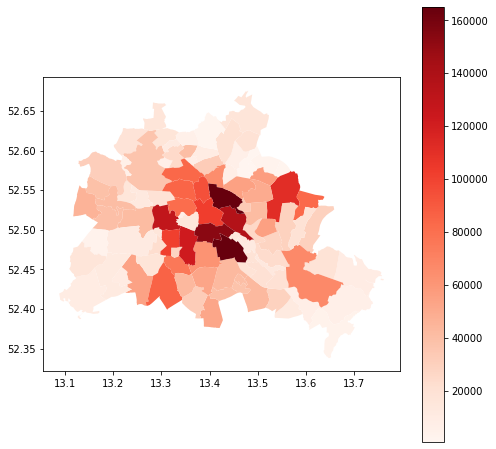

In [81]:
# plot population by zone
sm.zones.plot(column='pop', cmap = "Reds", legend=True, figsize = (8,8))

<AxesSubplot:>

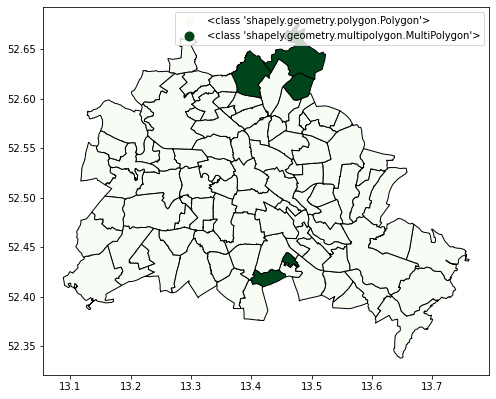

In [82]:
# plot zones by geometry type
sm.zones.plot(column = np.array(list(map(lambda x: type(x), sm.zones["geometry"]))),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use building height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [83]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones = sm.zones.drop(columns = [x for x in ['popCentroid', 'popCentroidOffset'] if x in sm.zones.columns])

In [84]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 32/32 [00:01<00:00, 23.71it/s]
